In [1]:
!python3 -m pip install scikit-learn
!python3 -m pip install seaborn

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from attrs import define
from abc import ABC, abstractmethod
from math import sqrt, atan2, hypot, sin, cos, pi, log
from typing import Optional, Tuple, List
from scipy.interpolate import griddata
from peak_detection import NausWallenstein

In [3]:
from test_generator import Line, generate_image, apply_general_noise
from polarization import\
    MaxComponentInertionPolarization,\
    InertionPolarization
from cell import Cell
from line_utils import abc2natural, natural2abc, draw_r_phi, draw_abc
from segmentation import grid_from_image, segments_detection, loop_segment_list
from peak_detection import NausWallenstein
from experiment import ExperimentData, run_exp

In [9]:
img = cv.imread("../test-images/thumb007.jpg", 0)
edges = cv.Canny(img, 30, 200)
img

array([[ 18,   0,   8, ..., 118, 124, 101],
       [  0,  15,  12, ..., 139, 146, 126],
       [ 11,   0,  14, ..., 166, 172, 158],
       ...,
       [246, 249, 253, ..., 252, 254, 255],
       [231, 235, 239, ..., 252, 254, 255],
       [219, 223, 229, ..., 252, 254, 255]], dtype=uint8)

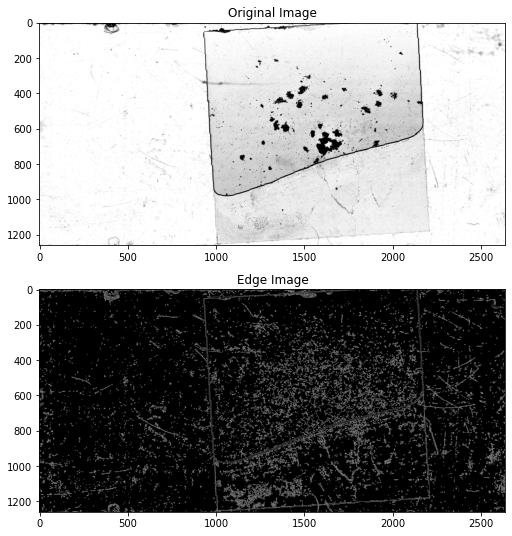

In [10]:
plt.figure(figsize=(15, 9))
plt.subplot(211)
plt.imshow(img, cmap = 'gray')
plt.title('Original Image')

plt.subplot(212)
plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image')
plt.show()

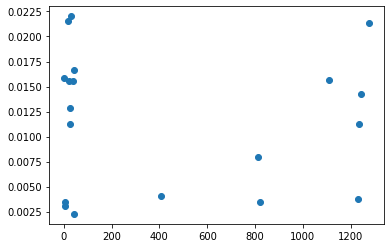

1.7616083099036234e-06 17.44452146771237
1.7616083099036234e-06 30.797247665944358
7.27922678676788 406.29023561436014
4.250783522997568 816.0520171917303
7.27922678676788 1107.4686823176805
0.9463031499513419 1236.6358171936247
7.27922678676788 1274.817908547224


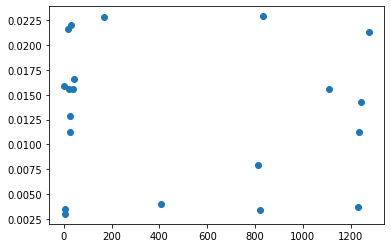

2.85806844177102e-06 17.44452146771237
6.332282789016047e-05 29.08084454924511
7.192321529098421 170.25924622739518
7.192321529098421 406.29023561436014
1.077327753926502 822.2702534285899
7.192321529098421 1107.4686823176805
1.077327753926502 1236.6358171936247
7.192321529098421 1274.817908547224


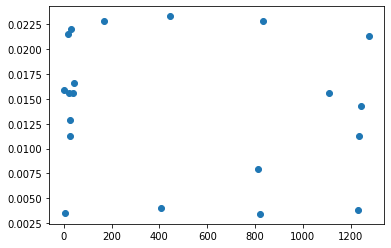

6.332282789016047e-05 18.989192366868025
6.332282789016047e-05 29.08084454924511
7.192321529098421 170.25924622739518
7.192321529098421 406.29023561436014
7.192321529098421 442.50429414508886
1.077327753926502 822.2702534285899
7.192321529098421 1107.4686823176805
1.077327753926502 1236.6358171936247
7.192321529098421 1274.817908547224


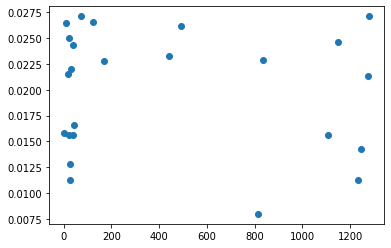

1.4769974602194868e-05 19.746556631527312
7.159810568078672e-07 25.70737172338898
7.159810568078672e-07 29.28549245148501
6.6074627651535245 73.7910745266472
6.6074627651535245 124.51873601773578
6.6074627651535245 170.25924622739518
6.6074627651535245 442.50429414508886
6.6074627651535245 490.8611520275526
5.645907009648715 823.7292363792571
6.6074627651535245 1107.4686823176805
6.6074627651535245 1147.0993104621602
5.645907009648715 1239.2922526607636
5.645907009648715 1276.211951646512


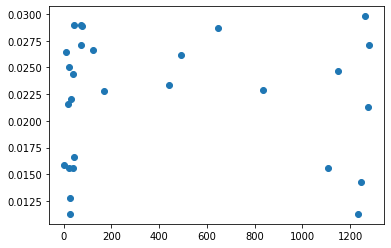

5.604835866953503e-05 19.746556631527312
3.401271180818096e-06 25.70737172338898
1.7395932988381165e-07 30.4360709585785
2.367434014338972 51.00631486068736
2.367434014338972 73.20682898378631
5.674789447695203 124.51873601773578
5.674789447695203 170.25924622739518
5.674789447695203 442.50429414508886
5.674789447695203 490.8611520275526
5.674789447695203 647.0962638209395
5.674789447695203 834.7067259023089
5.674789447695203 1107.4686823176805
5.674789447695203 1147.0993104621602
2.367434014338972 1246.3883236002348
2.367434014338972 1271.0014562574004


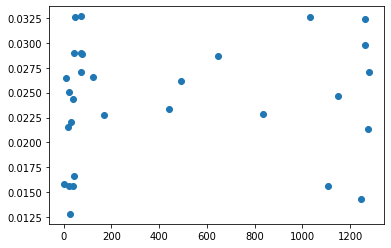

0.0012491674960397488 18.706405562794398
0.00010000941437490701 25.542341424730388
3.7789579129370846e-07 32.48264761229115
0.10342964107901442 54.22831529758294
0.10342964107901442 67.5486237714423
5.117264115482774 124.51873601773578
5.117264115482774 170.25924622739518
5.117264115482774 442.50429414508886
5.117264115482774 490.8611520275526
5.117264115482774 647.0962638209395
5.117264115482774 834.7067259023089
5.117264115482774 1033.541503524314
5.117264115482774 1107.4686823176805
5.117264115482774 1147.0993104621602
2.743335659016134 1256.0159083125352
0.6361503019536304 1269.1215058707962


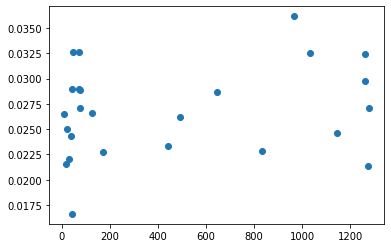

0.04459397976671273 23.392297255452256
0.0003382944327025181 33.92131871461852
0.04459397976671273 54.22831529758294
0.04459397976671273 67.5486237714423
6.4008586588492875 124.51873601773578
6.4008586588492875 170.25924622739518
6.4008586588492875 442.50429414508886
6.4008586588492875 490.8611520275526
6.4008586588492875 647.0962638209395
6.4008586588492875 834.7067259023089
6.4008586588492875 967.694839959367
6.4008586588492875 1033.541503524314
6.4008586588492875 1147.0993104621602
0.34222680063870914 1269.1215058707962


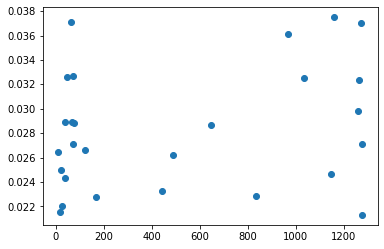

0.0639378063850778 23.392297255452256
0.006919201872121459 32.59204911342758
0.44664603198578234 47.55329245444446
0.0639378063850778 58.718372505760456
0.006919201872121459 67.01505686997723
5.932957612499931 124.51873601773578
5.932957612499931 170.25924622739518
5.932957612499931 442.50429414508886
5.932957612499931 490.8611520275526
5.932957612499931 647.0962638209395
5.932957612499931 834.7067259023089
5.932957612499931 967.694839959367
5.932957612499931 1033.541503524314
6.372374044868581 1154.0646470460142
0.0639378063850778 1270.0138264055875


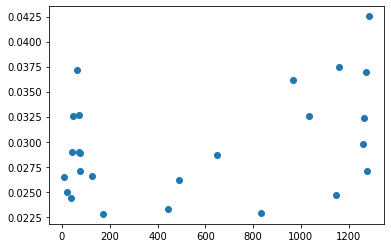

1.8265113188310558 23.232456662516423
0.338546708507788 37.07204459771336
0.338546708507788 47.55329245444446
0.043898665604941996 58.718372505760456
0.004289583016592252 67.01505686997723
6.452429042708223 124.51873601773578
6.452429042708223 170.25924622739518
6.452429042708223 442.50429414508886
6.452429042708223 490.8611520275526
6.452429042708223 647.0962638209395
6.452429042708223 834.7067259023089
6.452429042708223 967.694839959367
6.452429042708223 1033.541503524314
5.896957316443794 1154.0646470460142
0.043898665604941996 1271.756772198065


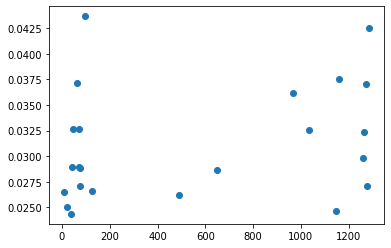

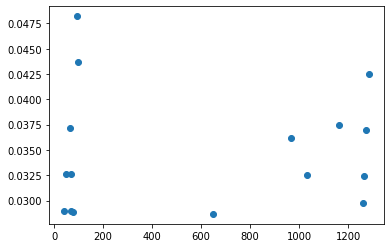

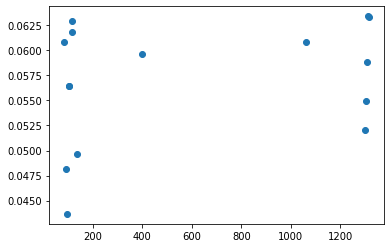

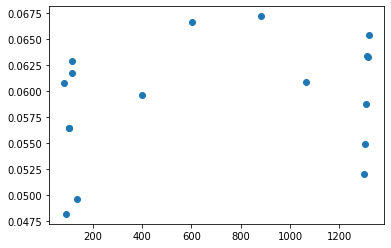

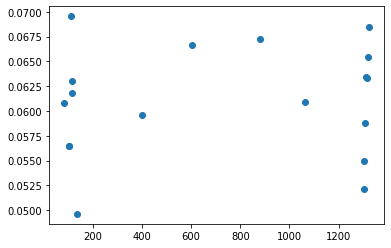

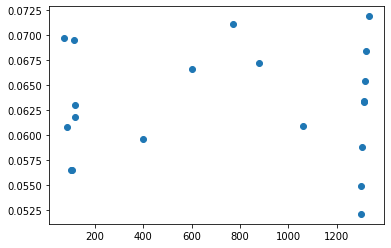

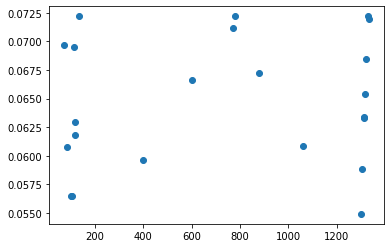

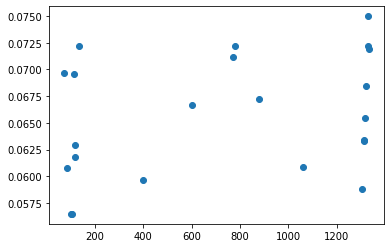

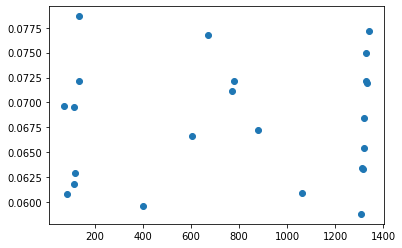

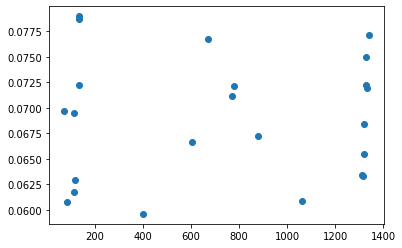

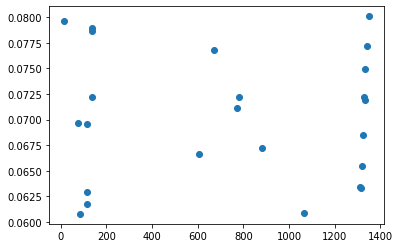

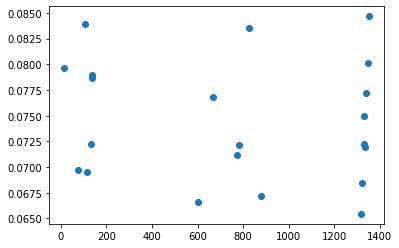

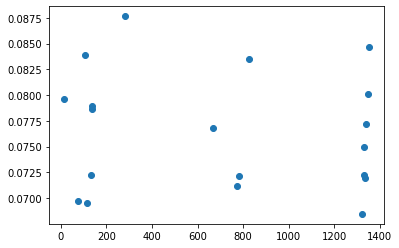

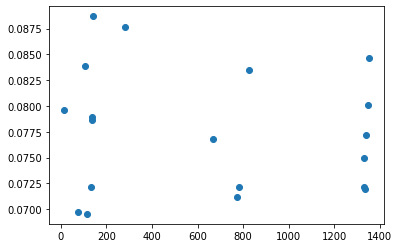

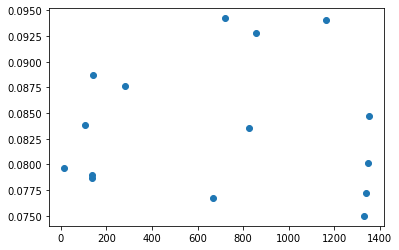

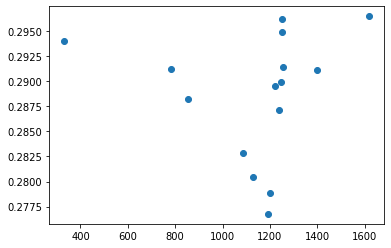

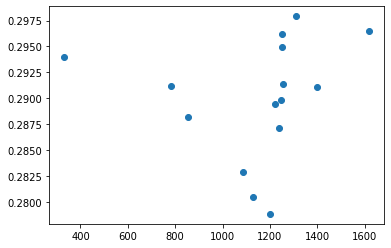

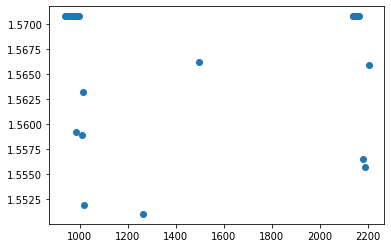

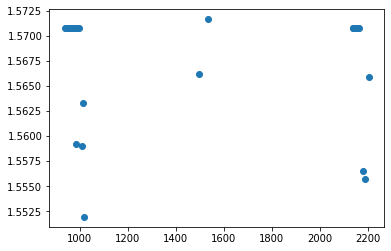

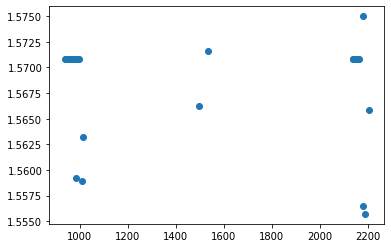

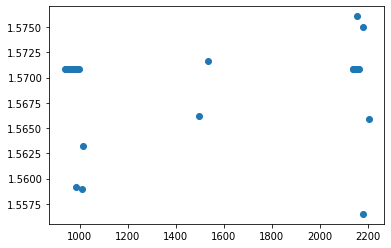

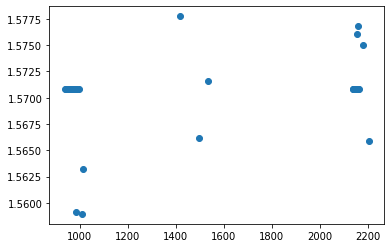

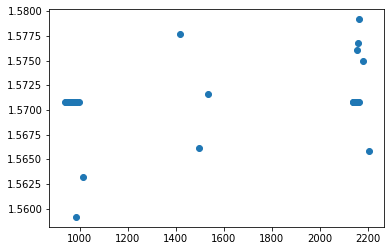

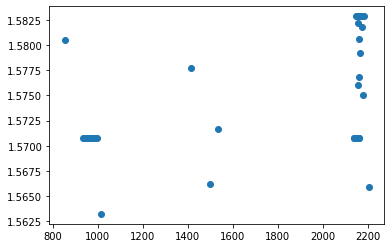

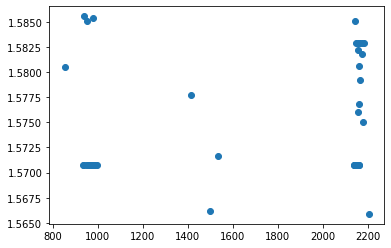

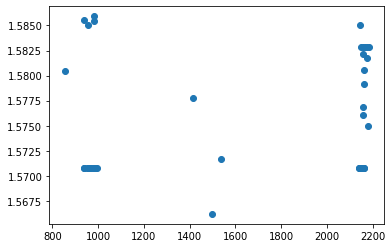

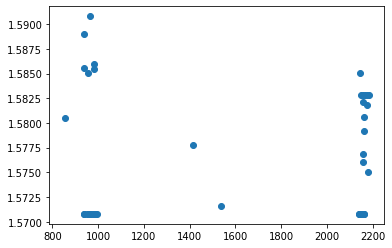

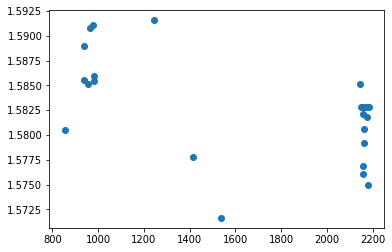

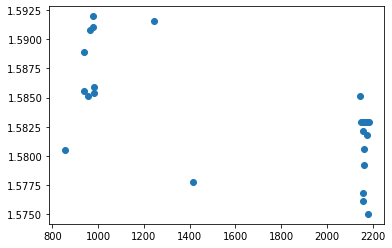

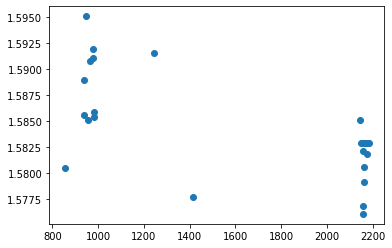

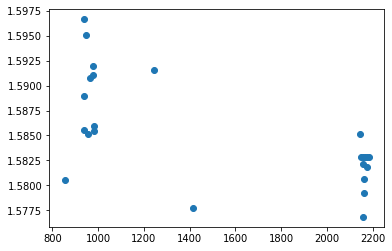

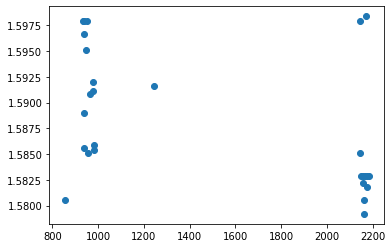

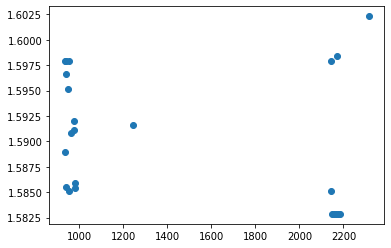

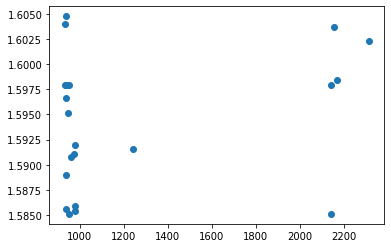

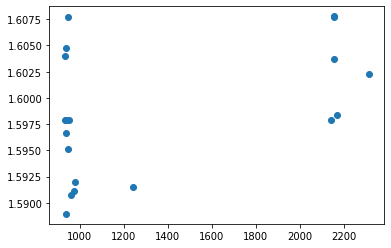

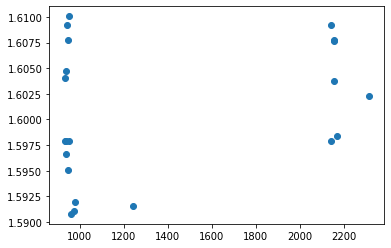

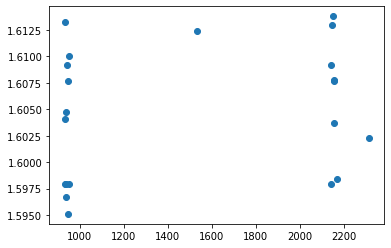

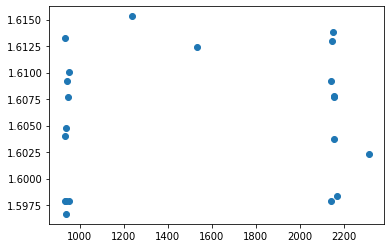

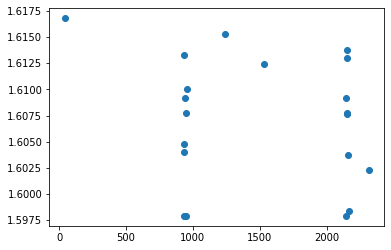

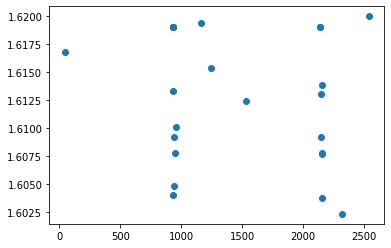

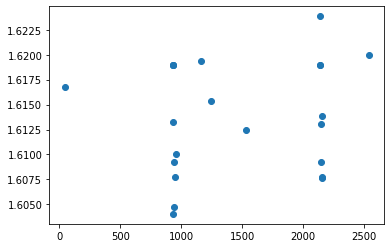

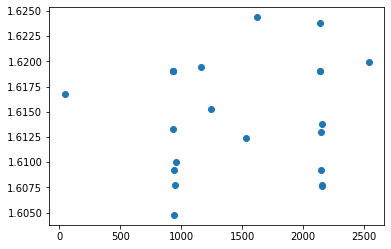

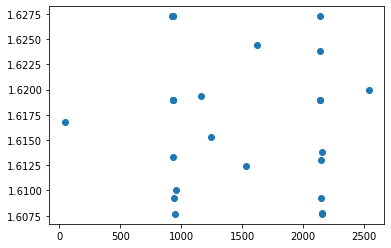

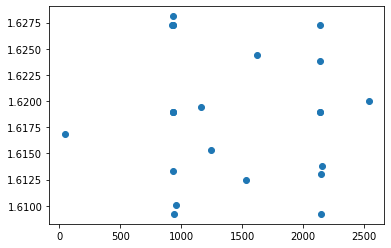

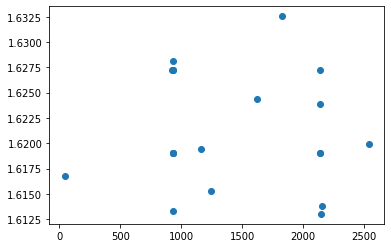

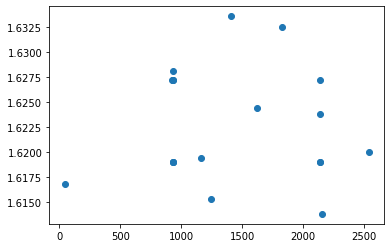

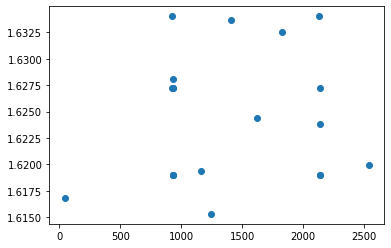

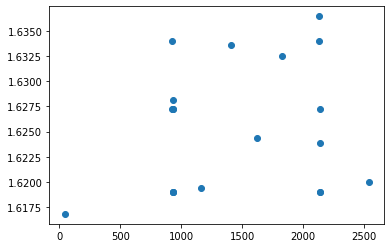

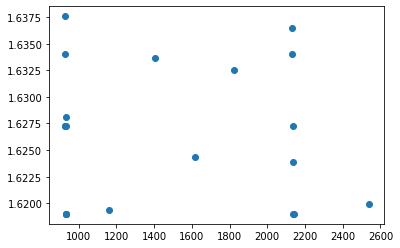

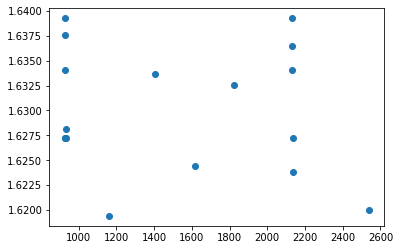

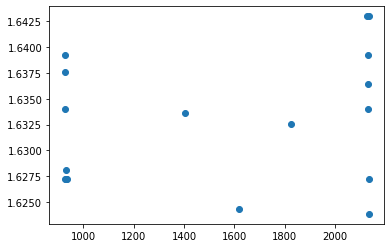

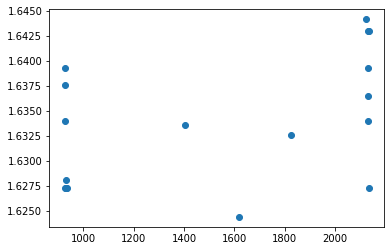

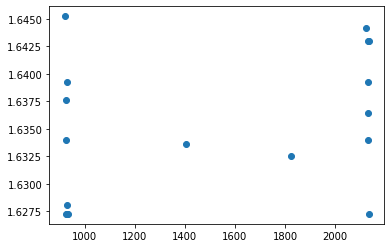

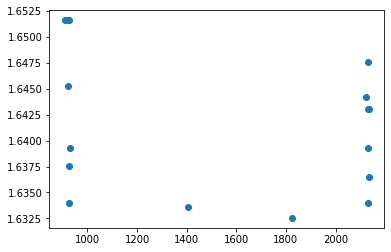

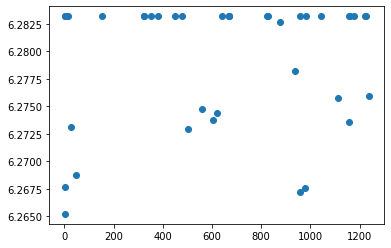

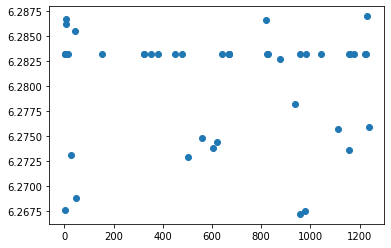

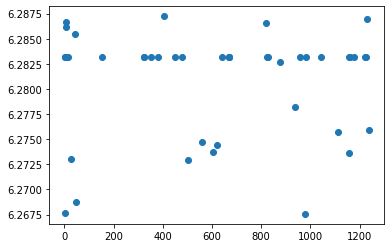

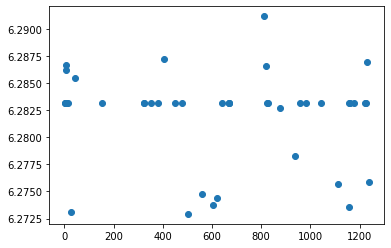

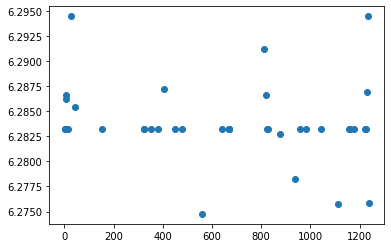

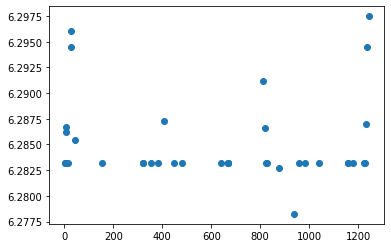

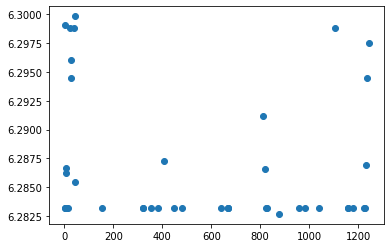

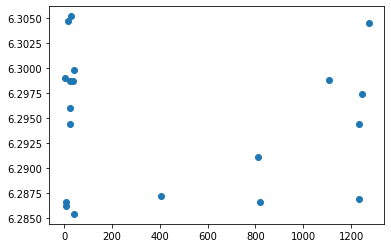

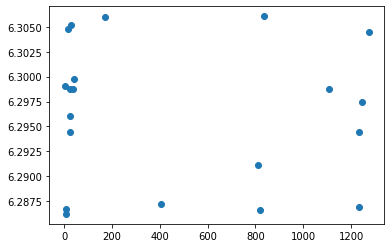

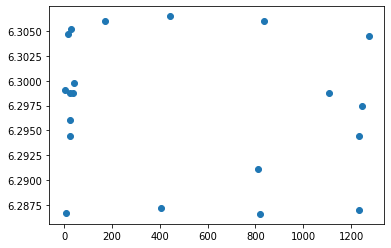

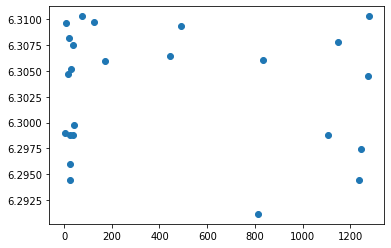

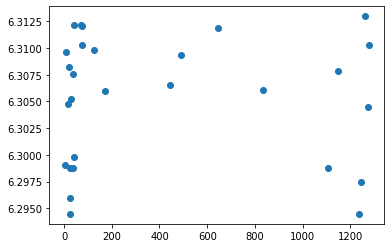

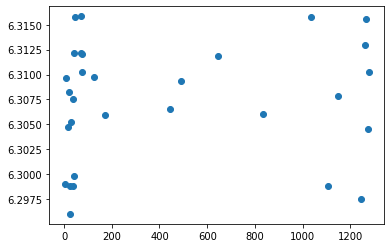

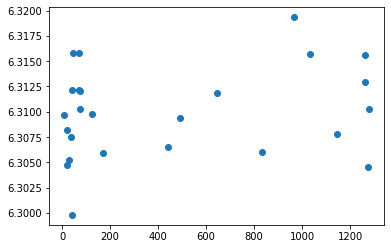

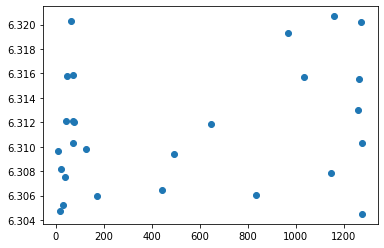

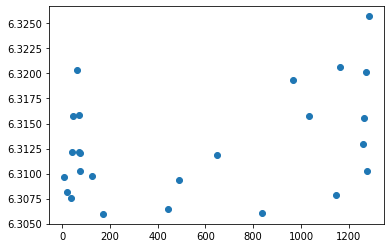

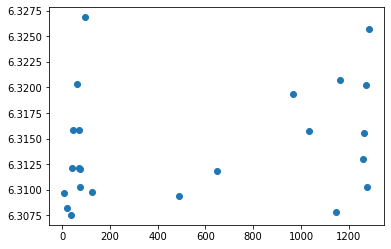

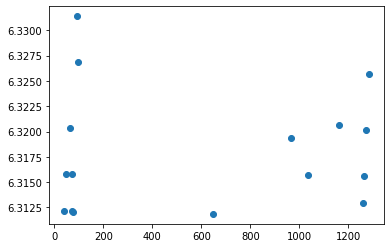

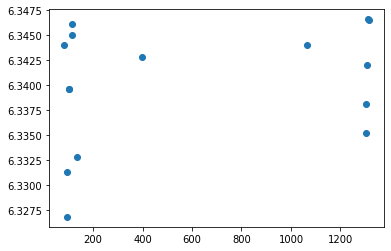

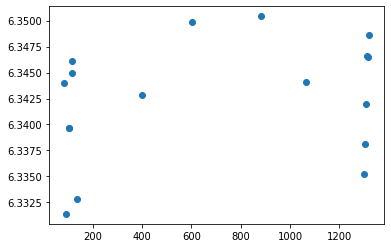

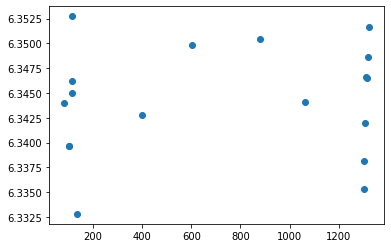

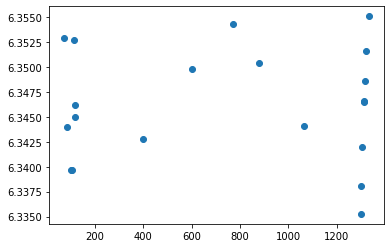

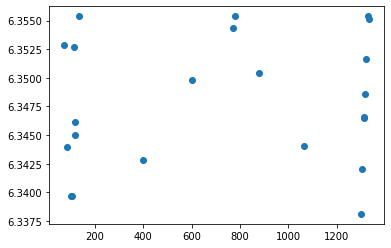

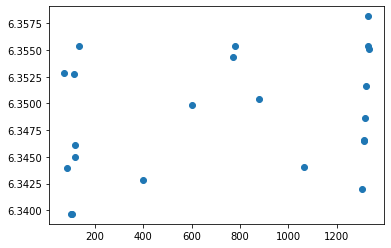

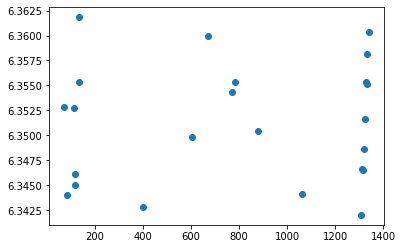

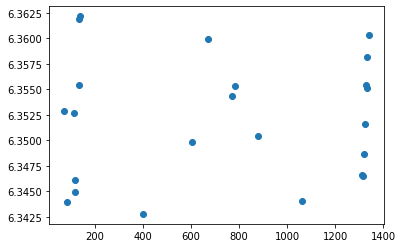

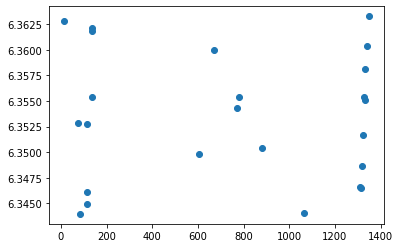

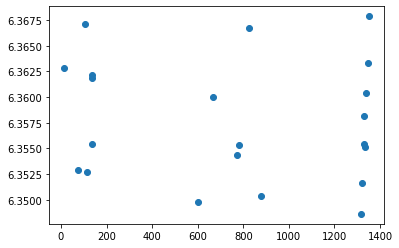

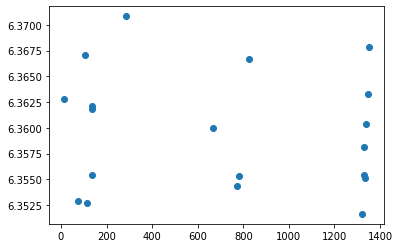

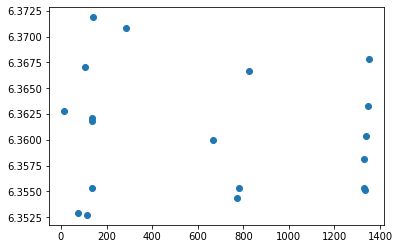

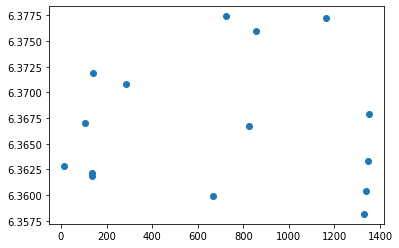

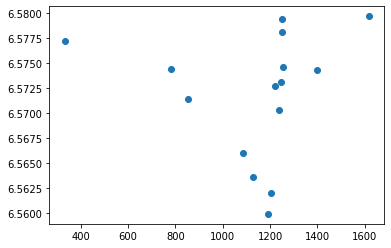

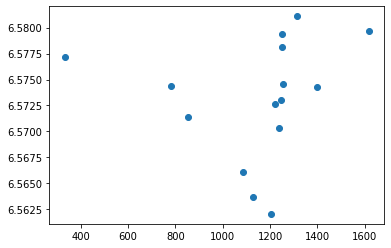

In [11]:
exp_data = run_exp(img, 20,
                   polarization_method=MaxComponentInertionPolarization(inertion=6),
                   peak_detection_method=NausWallenstein(alpha=0.01, r_window=30, phi_window=0.02))


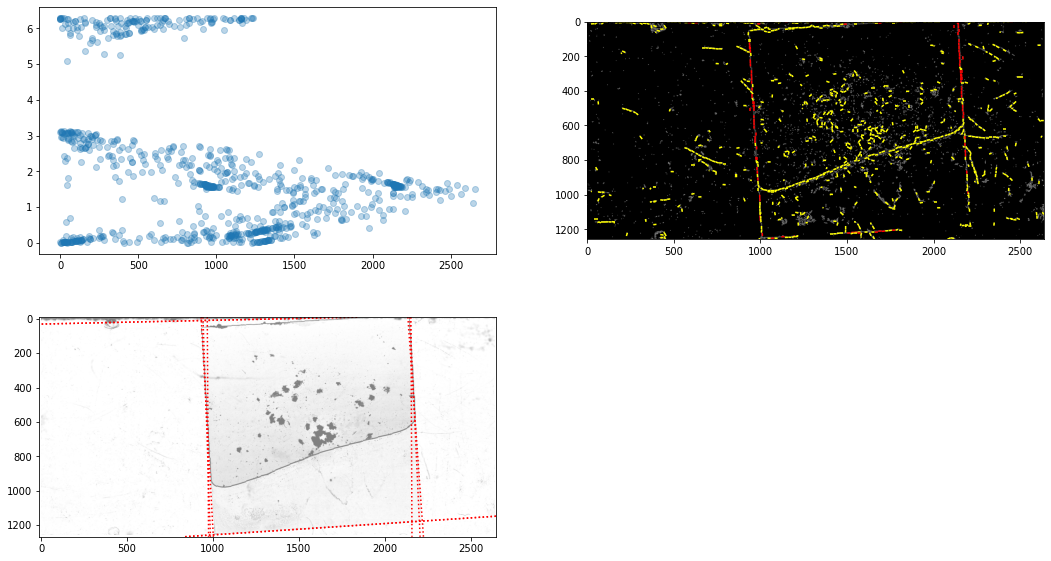

In [12]:
exp_data.visualize(compact=True)

In [8]:
print(len(list(filter(lambda x: abs(x[1]) < 0.03, lst))))

NameError: name 'lst' is not defined

In [ ]:
method = NausWallenstein(alpha=0.1)
peaks, windows = method.detect_peaks(lst, 5)

In [ ]:
window_list = list(windows.items())
window_list.sort(key=lambda x: x[0])
x, y = [], []
for i in window_list:
    x.append(i[0])
    y.append(i[1][0])
plt.plot(x, y)
print(*sorted(window_list, key=lambda x: x[1][0])[-40:])

In [ ]:
run_exp(img,
        10,
        compact=False,
        polarization_method=MaxComponentInertionPolarization(),
        peak_detection_method=NausWallenstein(alpha=1))

In [ ]:
current_img = generate_image([Line(1370, 0, 1, 0)], h=1500, w=2000)
plt.imshow(current_img)

In [ ]:
plt.imshow(current_img)
draw_abc(natural2abc((1370, 3.57)))
abc2natural(natural2abc((1370, 0)))

In [ ]:
for i in range(10):
    current_img = generate_image([Line(150, 1, 1, 0.1 * i)])
    apply_general_noise(current_img, lambda: np.random.normal(20, 50, 2), 0.02 * i )
    print("angular coeff = {}".format(0.01 * i))
    run_exp(current_img, grid_size=10, compact=True, polarization_method=MaxComponentInertionPolarization(), lines_count=3)

In [ ]:
#x, y, c = zip(*segments)
#phi = list(map(lambda x: atan2(x[1], x[0]), zip(x, y)))
r, phi = zip(*segments)
plt.scatter(r, phi, alpha=0.1)

In [ ]:
eps = 0.01
by_neighbour_amount = []
for one in segments:
    count = 0
    for other in segments:
        if abs(one[0] - other[0]) < eps * 100 and abs(one[1] - other[1]) < eps:#and abs(one[2] - other[2]) < eps:
            count += 1
    by_neighbour_amount.append((one, count))

In [ ]:
by_neighbour_amount.sort(key=lambda x: -x[1])

In [ ]:
plt.imshow(test_img, cmap='gray')
for i in range(20):
    print(by_neighbour_amount[i])
    draw_r_phi(by_neighbour_amount[i][0])

In [ ]:
arr = [(1, 2,3), (4, 5, 6)]
np.array(arr)

In [ ]:
np.zeros(5)

In [ ]:
for i, elem in enumerate(arr):
    print(i, elem)